# Dashcam Vehicle Detection with Computer Vision
## Jules GIRAUD

In this project, the goal is to implement a system that can detect vehicles in dashcam videos using traditional computer vision techniques. The primary challenge is to identify vehicles in various frames of a video and output bounding boxes around them.

## Dataset
To train my car detection system, I used the [”Vehicle Detection Image Set”](https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set) found on Kaggle. This dataset consists of 17,760 labeled images, with 8,968 non-vehicle and 8,792 vehicle instances. Each image has a resolution of 64x64 pixels and contains three color channels (RGB).
The prediction are made on the Kaggle challenge test set (Not the one I train my model).

## Evaluation

During the challenge the submissions are evaluated with respect to the Sørensen–Dice coefficient,

$$DSC = \frac{2|X \cap Y|}{|X| + |Y|},$$

the intersection of the prediction X and the ground truth solution Y over the sum of their parts. The minimum is 0 (no intersection), and the maximum is 1 (perfect overlap). The mean DSC over all test images is your final score. **N.B.** that although the challenge is posed as an object detection problem, it is evaluated as a segmentation problem i.e. X and Y will be binary masks (see below). This is due to some limitations of Kaggle as used in-class mode.

## Submitting to Kaggle

Submissions to the Kaggle challenge can be made in the form of a .csv file (see `sample_submission.csv`), consisting of two columns with one row per image:
```
Id,Predicted
test/001.jpg,192425 100 193705 100 ...
test/002.jpg,192425 100 193705 100 ...
test/003.jpg,192425 100 193705 100 ...
...
```
`Id` - the image id, which is the path to the image from the project root--must be exact.

`Predicted` - The [run length encoding](https://en.wikipedia.org/wiki/Run-length_encoding) of the binary mask resulting from your concatenated bounding boxes. It is recommended to use the supplied function `run_length_encoding` to automate this.

# Some data exploration

In [1]:
import pandas as pd

df_ground_truth = pd.read_csv('data/train.csv')
df_ground_truth.head()

,frame_id,bounding_boxes
0,train/A_001.jpg,0 225 214 317 0 172 345 254 285 240 155 131 70...
1,train/A_002.jpg,0 254 190 293 0 169 338 271 276 238 160 137 70...
2,train/A_003.jpg,0 306 59 241 0 155 306 318 235 233 191 149 713...
3,train/A_004.jpg,0 143 239 298 164 223 240 172 721 293 94 76 57...
4,train/A_005.jpg,0 217 137 270 55 209 323 208 731 296 99 79 573...


In [2]:
H, W = 720, 1280
N = len(df_ground_truth)

In [ ]:
from ipywidgets import interact, widgets
from IPython.display import display

def f_display(frame_id):
    u.show_annotation(df_ground_truth, frame_id)

interact(f_display, frame_id=widgets.IntSlider(min=0, max=N-1, step=1, value=0))

# Start of the implementation

In [1]:
# Import Modules and Libraries
%matplotlib inline
import os
import cv2
import time
import pickle
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import label
from skimage.io import imread
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import utils as u
import data_exploration as de
import hog as h
import detector as det

### Data exploration and dataset creation

In [4]:
# Data reading

# Data directories

# Laptop
vehicles_dir = '/data/vehicles'
non_vehicles_dir = '/data/non-vehicles'

cars = []
notcars = []
        
u.read_images(vehicles_dir, cars)
u.read_images(non_vehicles_dir, notcars)

# Define a test size for splitting :
test_size = 0.2
train_cars, test_cars = train_test_split(cars, test_size=test_size, random_state=42)
train_notcars, test_notcars = train_test_split(notcars, test_size=test_size, random_state=42)

We have in our list of images a count of:
 8792  cars
 8968  non-cars
We have in our list of images a count of:
 7033  train cars
 1759  test cars
We have in our list of images a count of:
 7174  train non-cars
 1794  test non-cars
The size of the images is:
 (64, 64, 3)
The data type is:
 float32
Example of Car images


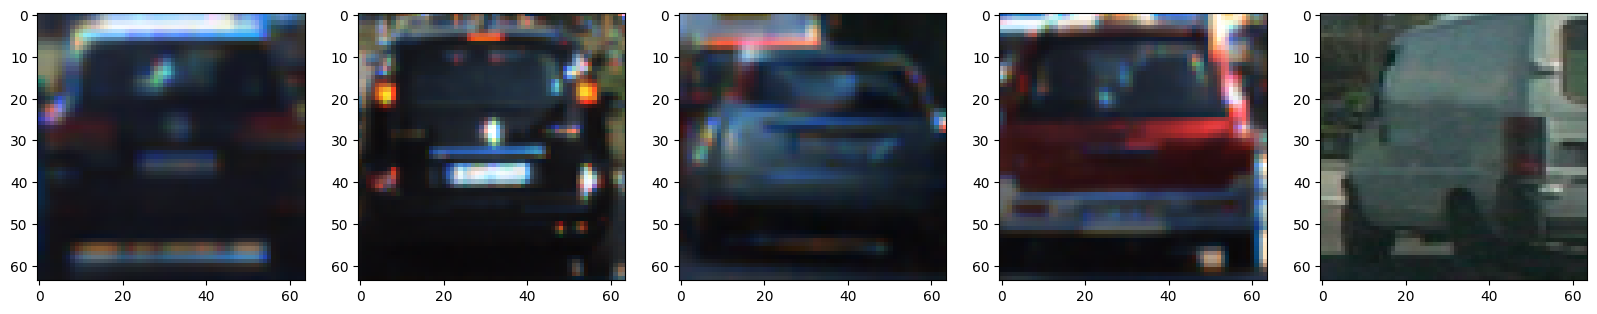

Example of non-car images


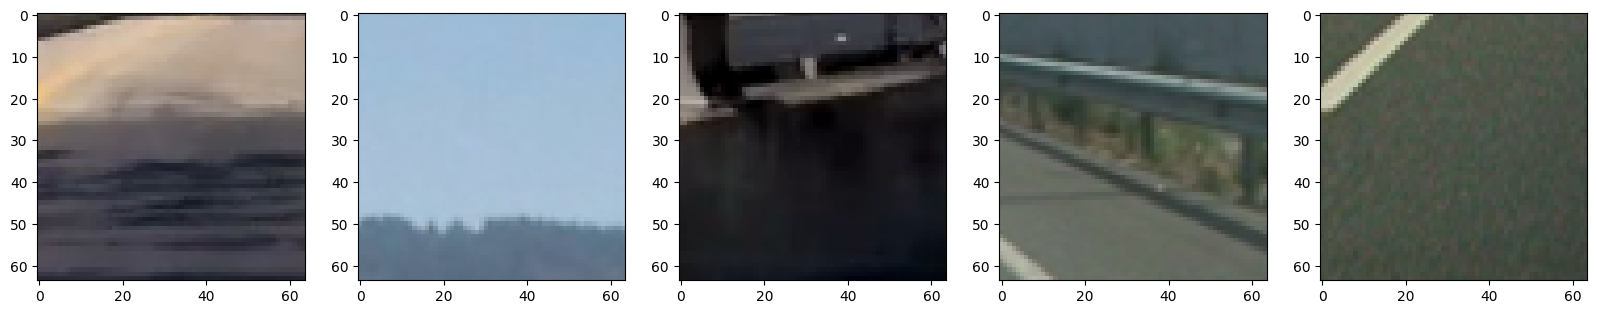

In [5]:
# Data information & Data visualization

# Image sample for data information
sample_car_img = mpimg.imread(cars[0])

# Parameters for data visualization
num_img = 5 # nb of img you want to visualize
cars_samples = random.sample(list(cars), num_img)
notcar_samples = random.sample(list(notcars), num_img)

# Read some car and not-car images
car_images = [mpimg.imread(sample) for sample in cars_samples]
notcar_images = [mpimg.imread(sample) for sample in notcar_samples]

de.data_information(cars, notcars, train_cars, test_cars, train_notcars, test_notcars, sample_car_img)
de.visualize_cars_and_ncars_images(car_images, num_img, "Example of Car images")
de.visualize_cars_and_ncars_images(notcar_images, num_img, "Example of non-car images")

### Exploring HOG features

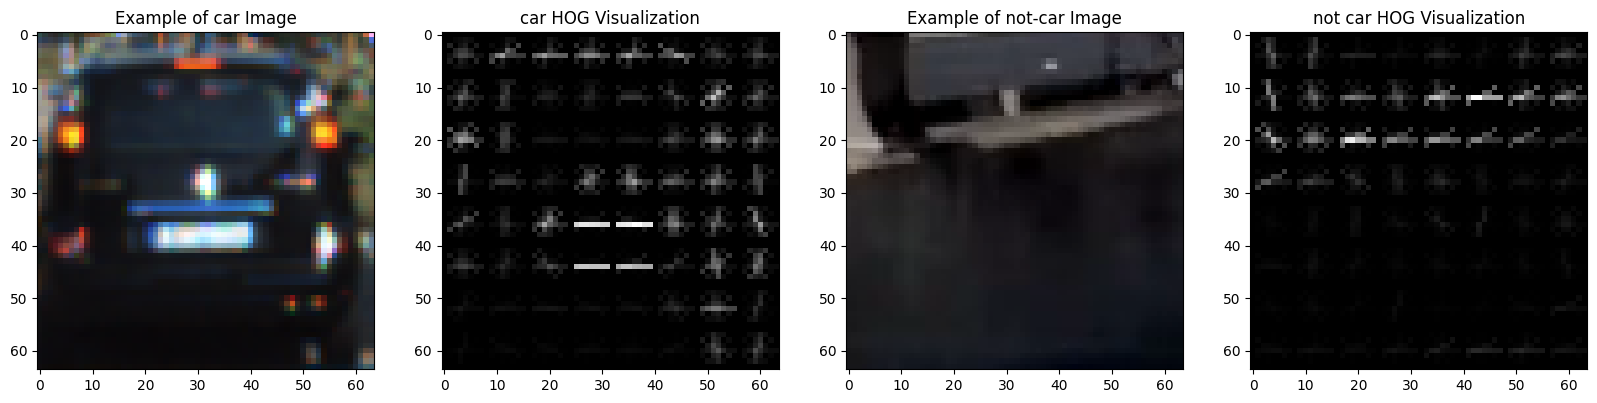

In [6]:
orientations = 9
pix_per_cell = 8
cell_per_block = 2

car_features, hog_image = h.get_hog_features(cv2.cvtColor(car_images[1], cv2.COLOR_RGB2GRAY), orientations, pix_per_cell, cell_per_block, 
                        visualize=True, feature_vector=True)

notcar_features, notcar_hog_image = h.get_hog_features(cv2.cvtColor(notcar_images[2], cv2.COLOR_RGB2GRAY), orientations, pix_per_cell, cell_per_block, 
                        visualize=True, feature_vector=True)
    
de.examples_hog_plot(car_images[1], hog_image, notcar_images[2], notcar_hog_image)

### Extracting HOG features to train a model

In [38]:
### Set parameters (image 64x64 pixels)
color_space    = 'RGB'      # RGB, HSV, LUV, HLS, YUV or YCrCb
orientations   = 11         # HOG orientations
pix_per_cell   = 7          # HOG pixels per cell
cell_per_block = 2          # HOG cells per block
hog_channel    = 'ALL'      # 0, 1, 2, or "ALL"
spatial_size   = (32, 32)   #(32, 32)
hist_bins      = 32         # Number of histogram bins (default 32)

# Select features
spatial_feat   = False      # Spatial features used or not
hist_feat      = True       # Histogram features used or not
hog_feat       = True       # HOG features used or not

In [39]:
# Extract features from cars and non cars images
t0=time.time()

car_features = h.extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orientations=orientations, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(len(car_features[0]),'Car features extracted')

notcar_features = h.extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orientations=orientations, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print(len(notcar_features[0]),'Non car features extracted')

X = np.vstack((car_features, notcar_features)).astype(np.float64) 
t1 = time.time()

print('\n --- HOG parameters ---')
print('Using these parameters for hog features:')
print(orientations, 'orientations')
print(pix_per_cell, 'pixels per cell')
print(cell_per_block, 'cells per block')
print(round(t1-t0, 2), 'seconds to extract',len(car_features[0]),'features.')

8544 Car features extracted
8544 Non car features extracted

 --- HOG parameters ---
Using these parameters for hog features:
11 orientations
7 pixels per cell
2 cells per block
100.23 seconds to extract 8544 features.


In [40]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Printing the scaled_X shape
print('Scaled_X shape: ', scaled_X.shape)

(17760, 8544)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

# Make sure the train/test splits are balanced
train_cars_percentage = len(y_train[y_train == 1])/len(y_train) * 100
train_notcars_percentage = 100 - train_cars_percentage
test_cars_percentage = len(y_test[y_test == 1])/len(y_test) * 100
test_notcars_percentage = 100 - test_cars_percentage

print("Training split size is {:d} samples".format(y_train.shape[0]))
print("Testing split size is {:d} samples".format(y_test.shape[0]))
print("Percentages of cars & notcars samples in the training split is: {:.2f}% & {:.2f}%"
      .format(train_cars_percentage, train_notcars_percentage))
print("Percentages of cars & notcars samples in the test split is: {:.2f}% & {:.2f}%"
      .format(test_cars_percentage, test_notcars_percentage))
print("Feature vector length is:", len(X_train[0]))

Training split size is 14208 samples
Testing split size is 3552 samples
Percentages of cars & notcars samples in the training split is: 49.56% & 50.44%
Percentages of cars & notcars samples in the test split is: 49.30% & 50.70%
Feature vector length is: 8544


### SVM classification part

In [42]:
# Define the model

model = LinearSVC(dual=False)

# Train and Check the training time for the model
t=time.time()
model.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train the model.')
n_predict = 10
print('Test Accuracy of the model = {:.2f}'.format(model.score(X_test, y_test)))
print('My model predicts:   ', model.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

19.4 Seconds to train the model.
Test Accuracy of the model = 0.97
My model predicts:    [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
For these 10 labels:  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]


In [54]:
# Save the model

with open('model/Vehicle_Detection_SVC.pkl', 'wb') as pfile:
    pickle.dump(
        {
            'model': model,
            'scaler': X_scaler,
            'scaled': scaled_X,
            'orientations': orientations,
            'color_space': color_space,
            'ppc': pix_per_cell,
            'cpb': cell_per_block,
            'hog_cannels': hog_channel,
            'spatial_size': spatial_size,
            'histogram_bins': hist_bins,
            'Spatial features': spatial_feat,
            'Histogram features': hist_feat,
            'Hog features': hog_feat,            
        },
        pfile, pickle.HIGHEST_PROTOCOL)
print('Model and Scaler saved in pickle file')

Model and Scaler saved in pickle file


### Load & run the model on test images

In [2]:
# Load the model and stuff

pickle_dict = pickle.load(open('model/Vehicle_Detection_SVC.pkl', 'rb'))
print(pickle_dict)
model = pickle_dict['model']
X_scaler = pickle_dict['scaler']
orientations = pickle_dict["orientations"]
pix_per_cell = pickle_dict["ppc"]
cell_per_block = pickle_dict["cpb"]
spatial_size = pickle_dict["spatial_size"]
hist_bins = pickle_dict["histogram_bins"]

{'model': LinearSVC(dual=False), 'scaler': StandardScaler(), 'scaled': array([[ 0.        ,  0.        ,  0.        , ...,  0.02004949,
         1.07118115, -0.65372117],
       [ 0.        ,  0.        ,  0.        , ..., -0.68697178,
        -0.38473518, -0.28968735],
       [ 0.        ,  0.        ,  0.        , ...,  0.1121448 ,
         0.50024593,  2.79191219],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  2.38069574,
         0.18825557, -0.65372117],
       [ 0.        ,  0.        ,  0.        , ..., -0.95468046,
        -0.83046023, -0.65372117],
       [ 0.        ,  0.        ,  0.        , ...,  0.5857243 ,
         1.84786343, -0.0651438 ]]), 'orinetations': 11, 'color_space': 'RGB', 'ppc': 7, 'cpb': 2, 'hog_cannels': 'ALL', 'spatial_size': (32, 32), 'histogram_bins': 32, 'Spatial features': False, 'Histogram features': True, 'Hog features': True}


In [3]:
# Define the directory path for test images and load the images into an array

test_dir = '/data/test/'

test_images = []
images = glob.glob(test_dir + '*.jpg')
for image in images:
    test_images.append(mpimg.imread(image))

Number of windows for scale 0.5: 875
Number of windows for scale 1: 183
Number of windows for scale 1.25: 144
Number of windows for scale 2: 58


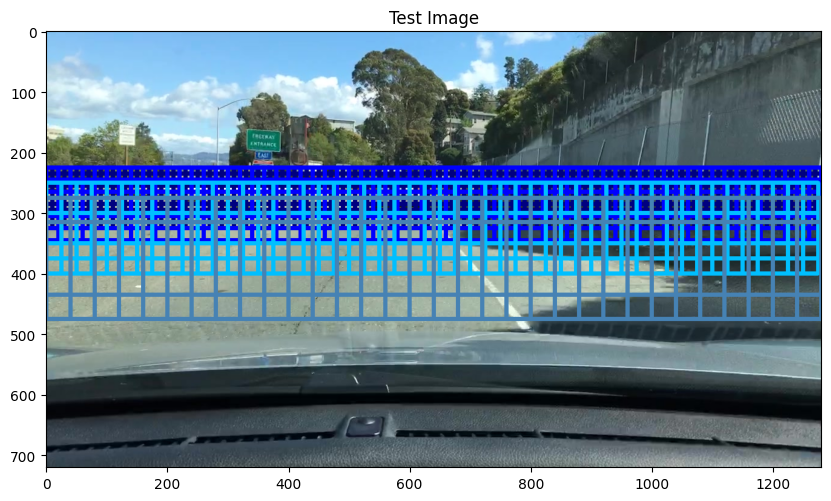

In [18]:
window_scale = (0.5, 1, 1.25, 2) #window scales to use 
xy_window = (80, 80) #size of initial window
xy_overlap = (0.75, 0.75) #overlap of search windows
x_start_stop = [0, 1280] #start and stop x-coordinates to search
y_start_stop = [[225, 325], [225, 350], [250, 400], [275, 500]] #start and stop y-coordinates to search
color_values = [(0, 0, 128), (0, 0, 255), (0, 191, 255), (70, 130, 180)]       
        
det.view_windows(test_images[3], window_scale, x_start_stop, y_start_stop, xy_window, xy_overlap, color_values)

## Creating a Kaggle submission file

Suppose we have a set of bounding boxes of format `x, y, width, height`:

For simplicity, let's say they are the same for all test images (yours won't be). Then, we can create a Kaggle submission file like this:

In [19]:
test_files = sorted(os.listdir('/data/test'))
data_path = '/data/test'

In [20]:
threshold_value = 0.25
result_images, result_boxes, heatmap_images, threshold_images, result_img_all_boxes = det.predict_on_test_images(test_files, data_path, window_scale, x_start_stop, y_start_stop, model, X_scaler, orientations, pix_per_cell, cell_per_block, spatial_size, hist_bins, threshold_value)

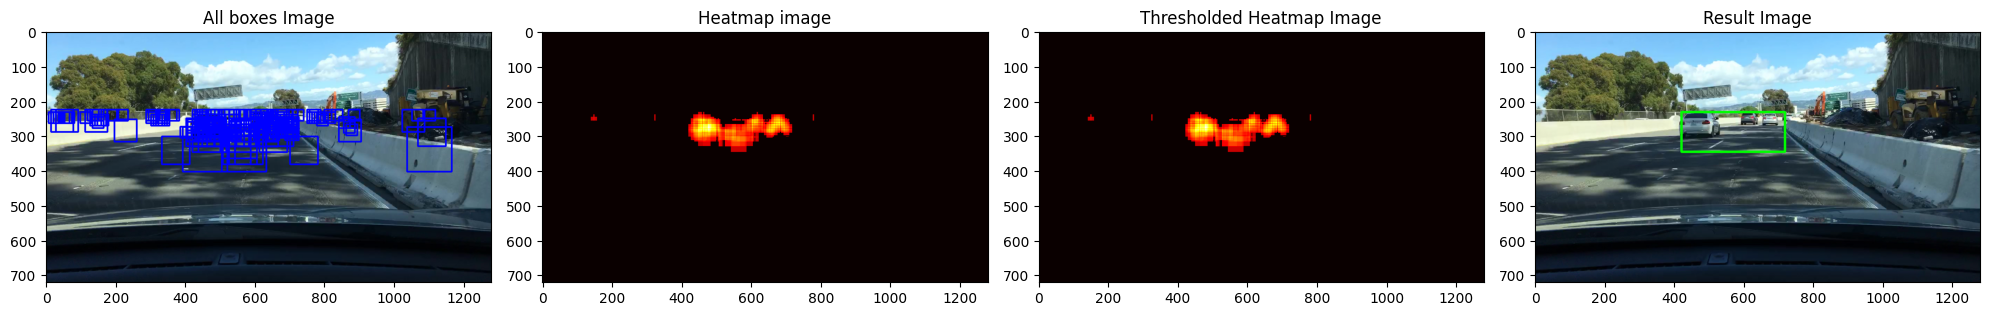

In [21]:
# Show results on test images
# Image index 0
de.detector_results(result_images, heatmap_images, threshold_images, result_img_all_boxes, 0)

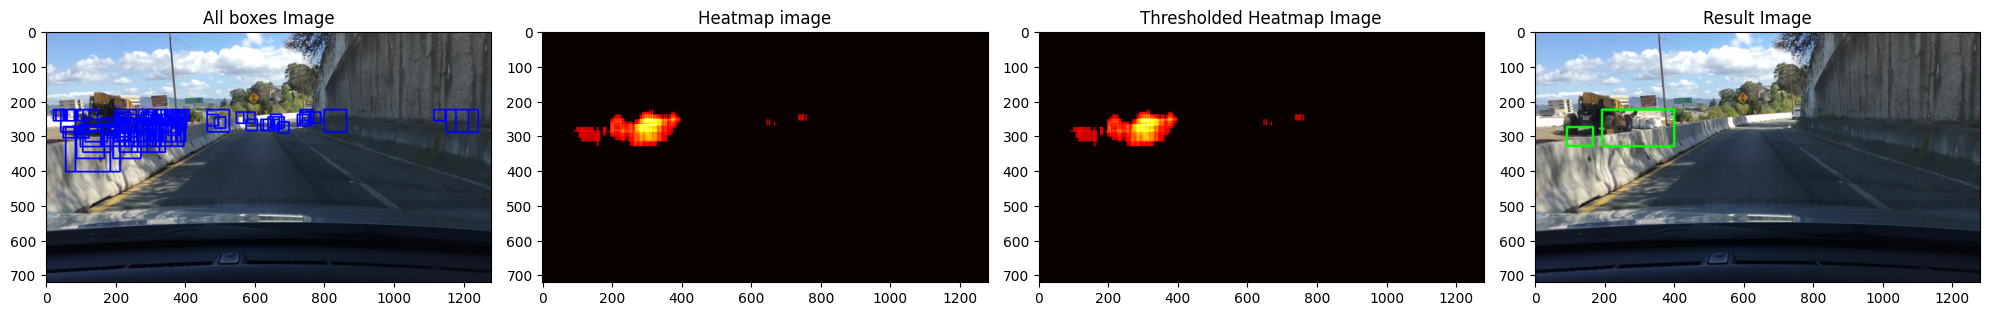

In [22]:
# Image index 80
de.detector_results(result_images, heatmap_images, threshold_images, result_img_all_boxes, 80)

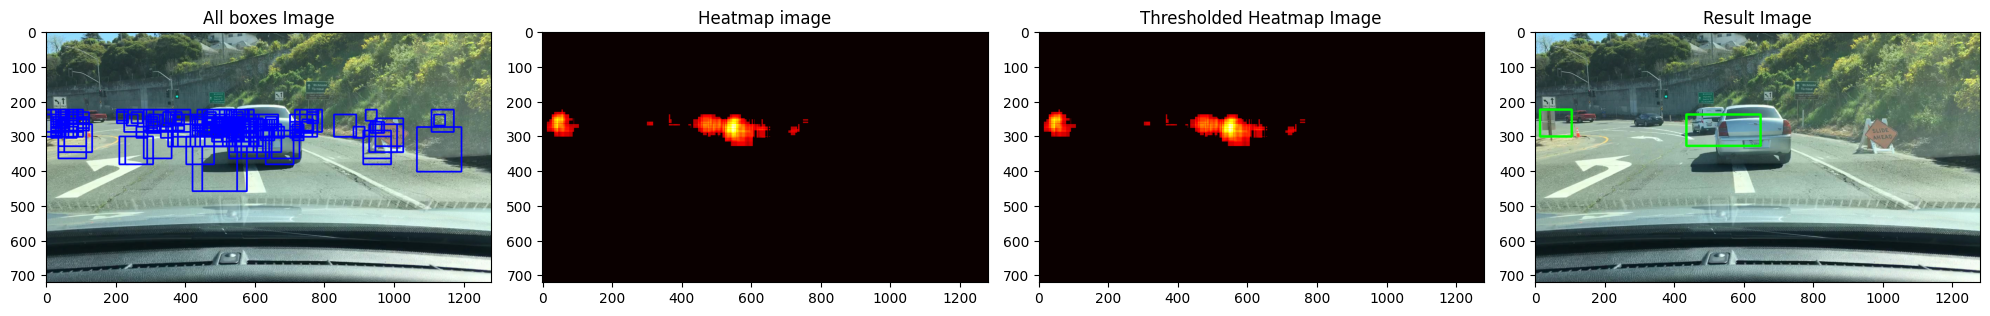

In [23]:
# Image index 160
de.detector_results(result_images, heatmap_images, threshold_images, result_img_all_boxes, 160)

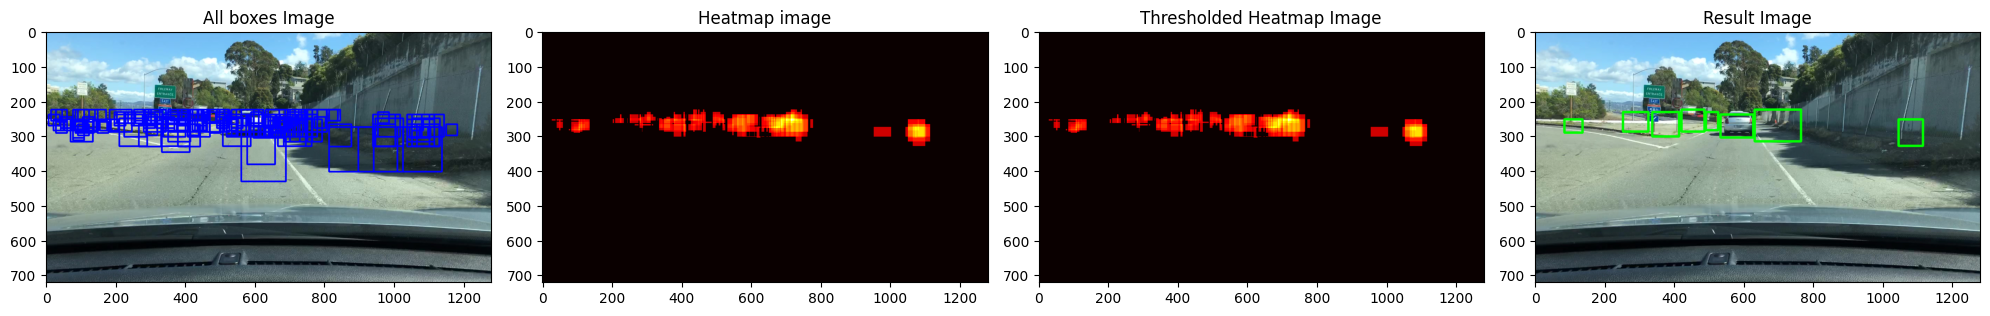

In [24]:
# Image index 200
de.detector_results(result_images, heatmap_images, threshold_images, result_img_all_boxes, 200)